# Title

authors: Bolzonello Enrico, Carlesso Daniel, Zordo Michele

## Dataset Setup

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import warnings
from toolbox import connect_poi

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

In [2]:
PLACE_NAME = "Padova, Veneto, Italy"

First we need the Padua street network, which we get from OpenStreetMap thanks to the Python library OSMnx

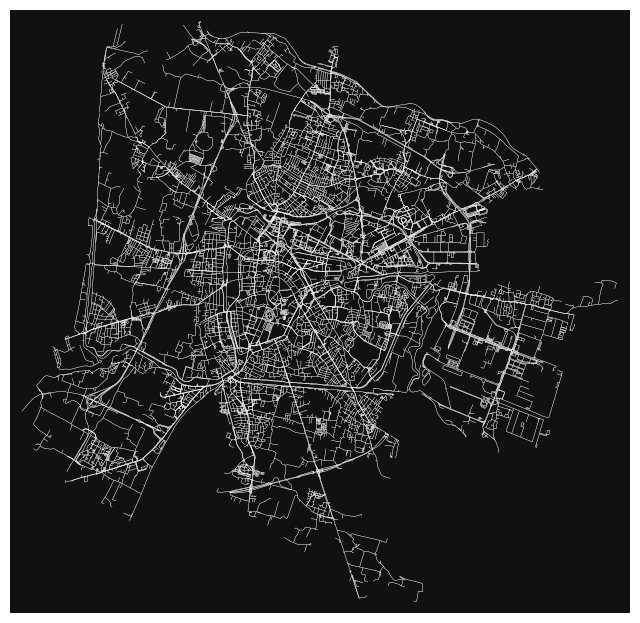

In [3]:
G_padova = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
fig, ax = ox.plot_graph(G_padova, node_size=0, edge_color="w", node_color="r",edge_linewidth=0.2)

In [4]:
len(G_padova)

20334

The number of nodes for the Padua street network is too large, since complex interchanges and roundabouts form clusters of nodes where the real connection is essentialy only one. So the next step is to simplify the street network, assuming nodes at maximum 15 meters are the same intersection

In [5]:
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G_padova_simplified)

5462

To make clear what's happening, let's make an example to see it visually.
This is the graph before simplification:

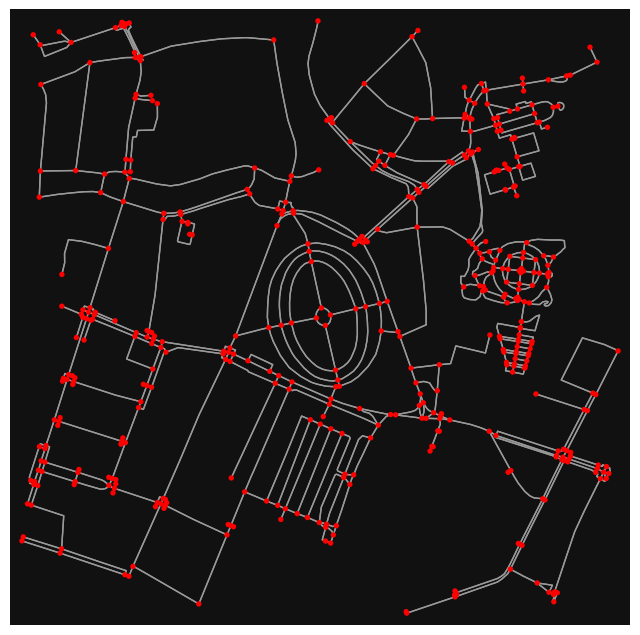

In [6]:
point = 45.39840,11.87644
G_ex = ox.graph_from_point(point, network_type="walk", dist=500)
fig, ax = ox.plot_graph(G_ex, node_color="r")

It is interesting to observe that complex intersections are represented by multiple nodes, which is not what we need.
After consolidating the intersections, the graph becomes:

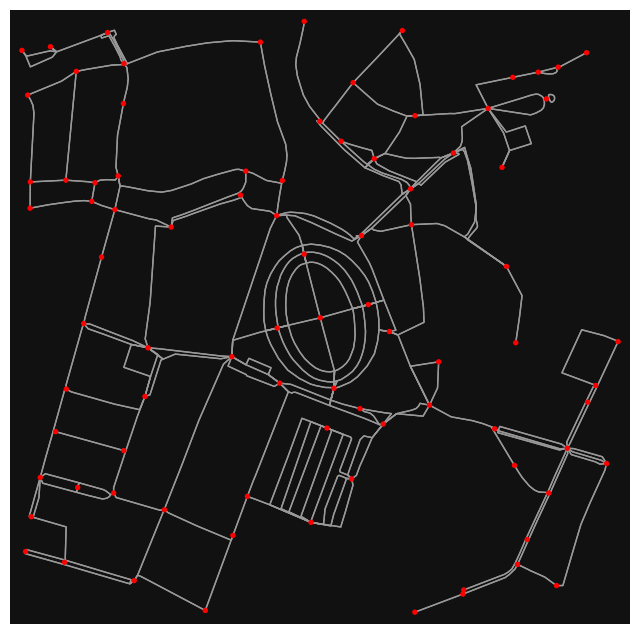

In [7]:
G_proj_ex = ox.project_graph(G_ex)
G_ex_simple = ox.consolidate_intersections(G_proj_ex, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G_ex_simple, node_color="r")

which conforms much better to modeling.
The drawback is an over-simplification of some connections, like the section at east of Prato della Valle, which is actually the Botanic garden, so simplifying to few nodes is not actually a big deal.
Another example is in the South, where there are a few close parallel connections, but it turns out to be a parking spot, so it is no big deal to over-simplify it.

In [8]:
nodes_gdf, edges_gdf = ox.utils_graph.graph_to_gdfs(G_padova_simplified)
nodes_gdf.head()

,osmid_original,x,y,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,,
0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,NaN,NaN,NaN,NaN,POINT (724701.900 5034203.206)
1,"[141542464, 522060005, 10964558191, 1855945754...",725125.264890,5.032994e+06,0,NaN,NaN,NaN,NaN,POINT (725125.265 5032993.789)
2,"[522060014, 206354760, 5392711449, 5392711456,...",725269.805793,5.032962e+06,0,NaN,NaN,NaN,NaN,POINT (725269.806 5032962.359)
3,"[141542473, 5792497355, 7086991412, 5798251594...",726160.105869,5.032901e+06,0,NaN,NaN,NaN,NaN,POINT (726160.106 5032900.781)
4,"[1113558376, 1101896841, 1101896807]",725349.659264,5.032934e+06,0,NaN,NaN,NaN,NaN,POINT (725349.659 5032934.463)


In [9]:
edges_gdf.head()

osmid                 highway  oneway  \
u v   key                                                          
0 236 0                244968982                    path   False   
      1                 41224006                tertiary   False   
      2    [23516585, 960693916]  [footway, residential]   False   
      3                244969034                    path   False   
  646 0                 24572542             residential   False   

                reversed      length  \
u v   key                              
0 236 0             True  118.807823   
      1             True  114.210076   
      2    [False, True]  135.210324   
      3            False  113.908091   
  646 0             True   84.733534   

                                                    geometry width  \
u v   key                                                            
0 236 0    LINESTRING (724701.900 5034203.206, 724686.915...     3   
      1    LINESTRING (724701.900 5034203.206, 724685.349...   NaN   
      2    LINESTRING (724701.900 5034203.206, 724691.464...   NaN   
      3    LINESTRING (724701.900 5034203.206, 724691.464...     3   
  646 0    LINESTRING (724701.900 5034203.206, 724715.964...   NaN   

           u_original  v_original lanes                     name maxspeed  \
u v   key                                                                   
0 236 0     254672751  1706766353   NaN                      NaN      NaN   
      1     254672878  2796391751     2  Via Annibale da Bassano      NaN   
      2    2522360919  2522409502   NaN  Via Annibale da Bassano      NaN   
      3    2522360919  2522360929   NaN                      NaN      NaN   
  646 0    2522360911   243487238   NaN                 Via Zara       30   

          bridge access service area junction tunnel est_width  ref  
u v   key                                                            
0 236 0      NaN    NaN     NaN  NaN      NaN    NaN       NaN  NaN  
      1      NaN    NaN     NaN  NaN      NaN    NaN       NaN  NaN  
      2      NaN    NaN     NaN  NaN      NaN    NaN       NaN  NaN  
      3      NaN    NaN     NaN  NaN      NaN    NaN       NaN  NaN  
  646 0      NaN    NaN     NaN  NaN      NaN    NaN       NaN  NaN

In [10]:
default_crs = str(G_padova_simplified.graph["crs"])
default_crs

'EPSG:32632'

### Point of Interests (POIs)

Let's define the POIs we are interested in, the full table can be found in the presentation paper.

In [11]:
# just for easy scalability
buildings_names = {
    "education": ["school", "kindergarten", "library"],
    "bank": ["bank", "atm"],
    "healthcare": ["clinic", "doctors", "hospital", "pharmacy"],
    "transportation": ["stop_position"],
    "food": ["supermarket","convenience","greengrocer"]
}

For each group, let's create a GeoDataFrame and save it in another dictionary for easy access.

In [12]:
buildings_gdf = dict.fromkeys(buildings_names.keys())
for type in buildings_gdf.keys():
    # set the key (based on OSM specification)
    poi_key = "amenity"
    if type == "transportation":
        poi_key = "public_transport"
    if type == "food":
        poi_key = "shop"

    # set the value (simply the array)
    poi_value = buildings_names[type]

    # create the GeoDataFrame
    buildings_gdf[type] = ox.features_from_place(
            PLACE_NAME,
            {poi_key: poi_value}
        )

    # convert to the same crs as the graph
    buildings_gdf[type].to_crs(crs=default_crs, inplace=True)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/releas

In [13]:
# just for checking that the crs is set accordingly
for t in buildings_gdf.keys():
    print(buildings_gdf[t].crs)

EPSG:32632
EPSG:32632
EPSG:32632
EPSG:32632
EPSG:32632


In [14]:
buildings_gdf["food"].columns

Index(['addr:housenumber', 'addr:postcode', 'addr:street', 'check_date',
       'name', 'opening_hours', 'shop', 'website', 'wheelchair', 'geometry',
       'brand', 'brand:wikidata', 'addr:city', 'brand:wikipedia', 'level',
       'operator', 'payment:bancomat', 'payment:cash', 'payment:credit_cards',
       'phone', 'addr:unit', 'ref:vatin', 'payment:debit_cards',
       'operator:wikidata', 'operator:wikipedia', 'delivery:covid19',
       'delivery:description:it', 'addr:country', 'survey:date', 'email',
       'facebook', 'toilets', 'addr:hamlet', 'branch', 'contact:phone',
       'building', 'source', 'name:en', 'origin', 'organic', 'sells:tobacco',
       'delivery', 'phone:covid19', 'contact:whatsapp', 'fixme', 'addr:suburb',
       'description', 'url', 'start_date', 'air_conditioning', 'second_hand',
       'nodes', 'payment:contactless', 'brand:website', 'building:levels',
       'contact:website', 'smoking', 'note'],
      dtype='object')

In [15]:
buildings_gdf["food"].head()

addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                        
node         256072065               31         35138  Via Monte Cengio   
             296955042              NaN           NaN               NaN   
             296955316              NaN           NaN               NaN   
             296963264              NaN           NaN               NaN   
             334511575               61         35131       Via Venezia   

                        check_date      name  \
element_type osmid                             
node         256072065  2023-09-19  Eurospar   
             296955042         NaN      Metà   
             296955316         NaN  Eurospar   
             296963264         NaN         D   
             334511575         NaN     Conad   

                                            opening_hours         shop  \
element_type osmid                                                       
node         256072065  Mo-Sa 08:30-20:00; We 08:30-13:00  supermarket   
             296955042                                NaN  convenience   
             296955316                                NaN  supermarket   
             296963264                                NaN  supermarket   
             334511575                  Mo-Su 08:30-21:00  supermarket   

                                                                  website  \
element_type osmid                                                          
node         256072065  http://www.edespar.it/it/punti_vendita_scheda....   
             296955042                                                NaN   
             296955316                                                NaN   
             296963264                                                NaN   
             334511575  https://www.conad.it/ricerca-negozi/negozio.00...   

                       wheelchair                        geometry  ...  \
element_type osmid                                                 ...   
node         256072065        yes  POINT (723632.474 5032541.232)  ...   
             296955042        NaN  POINT (724512.660 5035388.753)  ...   
             296955316        NaN  POINT (724582.277 5036785.715)  ...   
             296963264        NaN  POINT (725772.090 5035923.059)  ...   
             334511575        yes  POINT (727563.488 5032836.529)  ...   

                       start_date air_conditioning second_hand nodes  \
element_type osmid                                                     
node         256072065        NaN              NaN         NaN   NaN   
             296955042        NaN              NaN         NaN   NaN   
             296955316        NaN              NaN         NaN   NaN   
             296963264        NaN              NaN         NaN   NaN   
             334511575        NaN              NaN         NaN   NaN   

                       payment:contactless brand:website building:levels  \
element_type osmid                                                         
node         256072065                 NaN           NaN             NaN   
             296955042                 NaN           NaN             NaN   
             296955316                 NaN           NaN             NaN   
             296963264                 NaN           NaN             NaN   
             334511575                 NaN           NaN             NaN   

                       contact:website smoking note  
element_type osmid                                   
node         256072065             NaN     NaN  NaN  
             296955042             NaN     NaN  NaN  
             296955316             NaN     NaN  NaN  
             296963264             NaN     NaN  NaN  
             334511575             NaN     NaN  NaN  

[5 rows x 58 columns]

In [28]:
pois['lon'] = pois['geometry'].apply(lambda p: p.x)
pois['lat'] = pois['geometry'].apply(lambda p: p.y)

AttributeError: 'Polygon' object has no attribute 'x'